As a start, we train a simple regressor MLP to predict the logprobs of the two-moons distribution from its coordinates. As a ground-truth for the logprobs we use a Kernel-density estimator. We also tried to use a Gaussian mixture model but this didn´t give us good values. We train the regressor with an MSE loss and with a KL divergence based loss and compare these. After finding optimal hyperparameters with Optuna, we train each optimal model repeatedly to check the mean and stddev of the quality of our models.

In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

import distributions as d
import evaluation as e
import models as m

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.trial import TrialState

c:\Users\Fritz\anaconda3\envs\analyzing_invs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global parameters

In [2]:
n_dim = 2
device = "cpu"

# Visualization of KDE we use for ground-truth

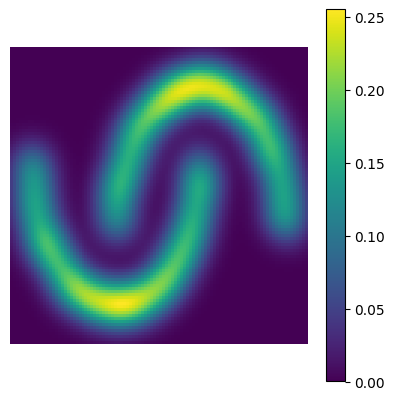

In [3]:
kde = d.moons_distribution()

grid = torch.stack(torch.meshgrid(torch.linspace(-2., 2., 100), torch.linspace(-2., 2., 100), indexing='xy'))
grid = grid.reshape(2, -1).T

logprobs = torch.Tensor(kde.score_samples(grid))

cax0 = plt.matshow(np.exp(logprobs).reshape(100,100), label="Density as estimated by KDE")
plt.axis("off")
cbar0 = plt.colorbar(cax0)

# Functions for training regressor model

In [5]:
def train_regressor(model, optimizer_name="Adam", lr=1e-4, epochs=500, 
                    batchsize=500, trial=None, train_with_kld=False, lr_schedule=False):
    optim = getattr(torch.optim, optimizer_name)(params=model.parameters(), lr=lr)
    if lr_schedule: lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)
    moons_dist = d.moons_distribution()
    mse_fn = nn.MSELoss()
    loss_history = []
    kld_history = []
    metrics = {}

    for epoch in tqdm.tqdm(range(epochs)):
        optim.zero_grad()
        x, _ = make_moons(batchsize, noise=0.1)
        scaler = StandardScaler()
        x_normalized = scaler.fit_transform(x)
        x = torch.Tensor(x_normalized)
        log_probs = moons_dist.score_samples(x)
        log_probs = torch.Tensor(log_probs).float().to(device)   
        pred = model(x)
        pred = torch.squeeze(pred)
        mse_loss = torch.mean(mse_fn(pred, log_probs))
        kld_loss = torch.mean(e.generalized_kl(pred, log_probs))
        
        if train_with_kld: kld_loss.backward()
        else: mse_loss.backward()
        optim.step()
        if lr_schedule: lr_scheduler.step(mse_loss)
        
        loss_history.append(mse_loss.item())
        kld_history.append(kld_loss.item())
        if trial is not None: trial.report(mse_loss.item(), epoch)
    metrics["mse_loss"] = loss_history
    metrics["kld_loss"] = kld_history
    return model, metrics

# Parameters for MSE training

In [6]:
mse_hidden_dim = 150
mse_n_layers = 3
mse_batchsize = 500
mse_lr = 0.0005
mse_optimizer = "Adam"
mse_epochs = 2000

# Training regressor with MSE Loss 

100%|██████████| 2000/2000 [02:08<00:00, 15.61it/s]


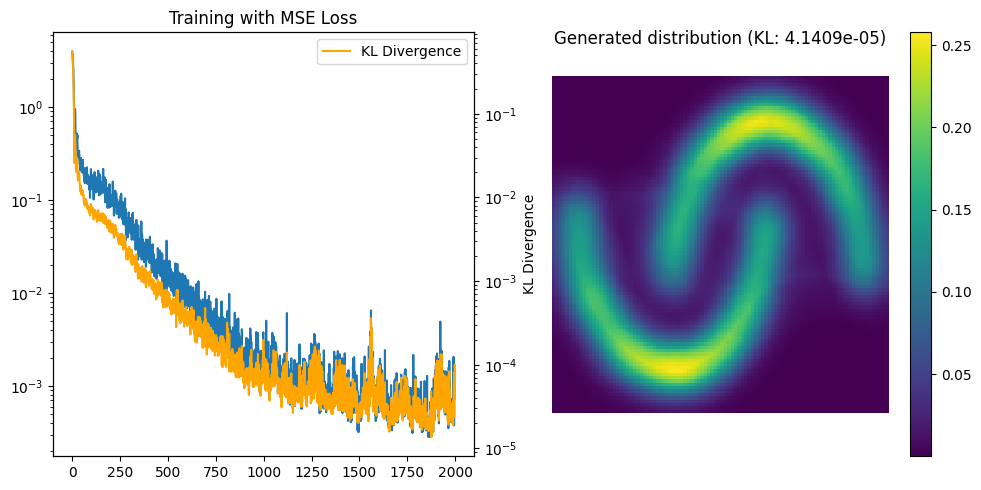

In [7]:
mse_regressor_net = make_regressor(n_dim, mse_hidden_dim, mse_n_layers)
mse_regressor_net, mse_metrics = train_regressor(mse_regressor_net, 
                                                 optimizer_name=mse_optimizer, 
                                                 epochs=mse_epochs, 
                                                 batchsize=mse_batchsize, 
                                                 lr=mse_lr)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

axs[0].plot(mse_metrics["mse_loss"])
axs[0].set_yscale("log")
axs[0].set_title("Training with MSE Loss")

ax2 = axs[0].twinx()
ax2.plot(mse_metrics["kld_loss"], label="KL Divergence", color="orange")
ax2.set_ylabel("KL Divergence")
ax2.set_yscale("log")

e.contour_plot(mse_regressor_net, axs[1])
axs[1].set_title(f"Generated distribution (KL: {e.kldiv(mse_regressor_net).mean().item():.4e})")

plt.legend()
plt.tight_layout()
plt.show()

# Parameters for training with KL Divergence

In [8]:
kld_hidden_dim = 150
kld_n_layers = 3
kld_batchsize = 500
kld_lr = 0.001
kld_optimizer = "Adam"
kld_epochs = 2000

# Training regressor with KL Divergence

100%|██████████| 2000/2000 [02:05<00:00, 15.99it/s]


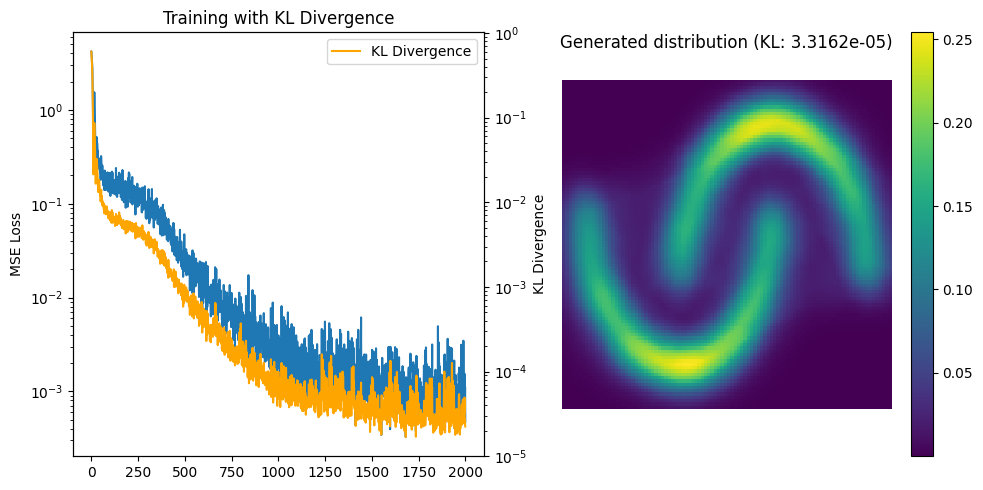

In [9]:
kld_regressor_net = m.make_regressor(n_dim, kld_hidden_dim, kld_n_layers)
kld_regressor_net, kld_metrics = train_regressor(kld_regressor_net,  
                                                 optimizer_name=kld_optimizer, 
                                                 epochs=kld_epochs, 
                                                 batchsize=kld_batchsize, 
                                                 lr=kld_lr, 
                                                 train_with_kld=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

axs[0].plot(kld_metrics["mse_loss"], label="MSE Loss")
axs[0].set_ylabel("MSE Loss")
axs[0].set_yscale("log")
axs[0].set_title("Training with KL Divergence")

ax2 = axs[0].twinx()
ax2.plot(kld_metrics["kld_loss"], label="KL Divergence", color="orange")
ax2.set_ylabel("KL Divergence")
ax2.set_yscale("log")

e.contour_plot(kld_regressor_net, axs[1])
axs[1].set_title(f"Generated distribution (KL: {e.kldiv(kld_regressor_net).mean().item():.4e})")

plt.legend()
plt.tight_layout()
plt.show()

# Test variance of quality

In [10]:
mse_training_kl_values = []
for i in range(5):
    mse_regressor_net = m.make_regressor(n_dim, mse_hidden_dim, mse_n_layers)
    mse_regressor_net, _ = train_regressor(mse_regressor_net, epochs=2000, 
                                            batchsize=mse_batchsize, lr=mse_lr)
    mse_training_kl_values.append(e.kldiv(mse_regressor_net).mean().item())
    
kld_training_kl_values = []
for i in range(5):
    kld_regressor_net = m.make_regressor(n_dim, kld_hidden_dim, kld_n_layers)
    kld_regressor_net, _ = train_regressor(kld_regressor_net, epochs=2000, 
                                            batchsize=kld_batchsize, lr=kld_lr, train_with_kld=True)
    kld_training_kl_values.append(e.kldiv(kld_regressor_net).mean().item())
    
print(f"Mean of KL Div. of MSE trained model: {np.mean(mse_training_kl_values):.4e}")
print(f"Stddiv of KL Div. of MSE trained model: {np.std(mse_training_kl_values):.4e}")
print(f"Mean of KL Div. of KLD trained model: {np.mean(kld_training_kl_values):.4e}")
print(f"Stddiv of KL Div. of KLD trained model: {np.std(kld_training_kl_values):.4e}")    

100%|██████████| 2000/2000 [02:01<00:00, 16.51it/s]

Mean of KL Div. of MSE trained model: 5.7503e-05
Stddiv of KL Div. of MSE trained model: 6.2221e-05
Mean of KL Div. of KLD trained model: 4.7521e-05
Stddiv of KL Div. of KLD trained model: 1.0480e-05


# Optuna Optimization for MSE Loss Training
hidden_dim: 207;
n_layers: 4;
lr: 0.0026603648591819276;
optimizer: Adam;
batchsize: 456

In [22]:
def define_model(trial):
  hidden_dim = trial.suggest_int("hidden_dim", 4, 256)
  n_layers = trial.suggest_int("n_layers", 1, 5)
  layers = [nn.Linear(n_dim, hidden_dim), nn.ReLU()]
  for _ in range(n_layers):
      layers.append(nn.Linear(hidden_dim, hidden_dim))
      layers.append(nn.ReLU())
  layers.append(nn.Linear(hidden_dim, 1))
  regressor_net = nn.Sequential(*layers)
  return regressor_net

def mse_objective(trial):
  model = define_model(trial).to(device)

  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  batchsize = trial.suggest_int("batchsize", 1, 500)

  _, metrics = train_regressor(model, trial=trial, epochs=1000, batchsize=batchsize, lr=lr)
  loss = metrics["kld_loss"]
  return np.mean(loss[-20:])

def kld_objective(trial):
  model = define_model(trial).to(device)

  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  batchsize = trial.suggest_int("batchsize", 1, 500)

  _, metrics = train_regressor(model, trial=trial, epochs=500, batchsize=batchsize, lr=lr, train_with_kld=True)
  loss = metrics["kld_loss"]
  return np.mean(loss[-20:])

def run_study(study, objective, n_trials=30):
  study.optimize(objective, n_trials=n_trials, timeout=None)

  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

  print("Study statistics: ")
  print("  Number of finished trials: ", len(study.trials))
  print("  Number of pruned trials: ", len(pruned_trials))
  print("  Number of complete trials: ", len(complete_trials))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: ", trial.value)

  print("  Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
    
  fig = optuna.visualization.plot_param_importances(study)
  fig.show()

# Optuna Optimization of MSE trained model

In [23]:
mse_study = optuna.create_study(direction="minimize")
run_study(mse_study, mse_objective)

[I 2024-07-31 14:28:55,132] A new study created in memory with name: no-name-70cfa187-94f3-4e93-a68e-55be9de67c71
100%|██████████| 1000/1000 [00:21<00:00, 46.95it/s]
[I 2024-07-31 14:29:16,441] Trial 0 finished with value: 0.017454447317868473 and parameters: {'hidden_dim': 11, 'n_layers': 4, 'lr': 0.00026383373043950385, 'batchsize': 219}. Best is trial 0 with value: 0.017454447317868473.
100%|██████████| 1000/1000 [00:15<00:00, 63.62it/s]
[I 2024-07-31 14:29:32,190] Trial 1 finished with value: 0.00605172828072682 and parameters: {'hidden_dim': 63, 'n_layers': 3, 'lr': 0.0009896498601556008, 'batchsize': 106}. Best is trial 1 with value: 0.00605172828072682.
100%|██████████| 1000/1000 [00:31<00:00, 31.93it/s]
[I 2024-07-31 14:30:03,511] Trial 2 finished with value: 0.005406909179873765 and parameters: {'hidden_dim': 69, 'n_layers': 2, 'lr': 0.03688457745735888, 'batchsize': 330}. Best is trial 2 with value: 0.005406909179873765.
100%|██████████| 1000/1000 [00:37<00:00, 26.51it/s]
[I 

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  0
  Number of complete trials:  30
Best trial:
  Value:  0.0007874126225942746
  Params: 
    hidden_dim: 151
    n_layers: 3
    lr: 0.0010990819212465524
    batchsize: 499


# Optuna Optimization of KL Divergence trained model

In [24]:
kld_study = optuna.create_study(direction="minimize")
run_study(kld_study, kld_objective)

[I 2024-07-31 14:46:25,173] A new study created in memory with name: no-name-5bab74fd-fa2f-4bec-8191-3381498e1777
100%|██████████| 500/500 [00:07<00:00, 69.44it/s]
[I 2024-07-31 14:46:32,394] Trial 0 finished with value: 0.007589930715039372 and parameters: {'hidden_dim': 81, 'n_layers': 1, 'lr': 0.04306727168069971, 'batchsize': 106}. Best is trial 0 with value: 0.007589930715039372.
100%|██████████| 500/500 [00:09<00:00, 53.96it/s]
[I 2024-07-31 14:46:41,678] Trial 1 finished with value: 0.007169148977845907 and parameters: {'hidden_dim': 78, 'n_layers': 4, 'lr': 0.0014444889358976231, 'batchsize': 121}. Best is trial 1 with value: 0.007169148977845907.
100%|██████████| 500/500 [00:09<00:00, 51.48it/s]
[I 2024-07-31 14:46:51,407] Trial 2 finished with value: 0.008301777066662908 and parameters: {'hidden_dim': 120, 'n_layers': 1, 'lr': 0.04194765822544401, 'batchsize': 172}. Best is trial 1 with value: 0.007169148977845907.
100%|██████████| 500/500 [00:09<00:00, 50.11it/s]
[I 2024-07-

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  0
  Number of complete trials:  30
Best trial:
  Value:  0.00129276174120605
  Params: 
    hidden_dim: 239
    n_layers: 2
    lr: 0.007187801394290381
    batchsize: 497
